In [1]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [2]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [3]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [4]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()

In [5]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [15]:
def with_news_LSTM(company, df):
  len_df = df.shape[0]
  # Data Preprocessing
  # splitting training and testing data
  cols = ['adj_close','mean_compound']
  cols2 = ['date']
  split = 0.85
  i_split = int(len(df) * split)
  data_train = df.get(cols).values[:i_split]
  data_test  = df.get(cols).values[i_split:]
  data_test2  = df.get(cols2).values[i_split:]

  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  # Creating Windows for Test Data
  sequence_length=10
  data_windows_test = create_windows(data_test,len(data_test),sequence_length)
  # get original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  print('y_test_original.shape',y_test_original.shape)

  # Normalization of Test Data
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  # Train Data preparation
  data_windows = create_windows(data_train,len(data_train),sequence_length)
  normalized_data_train,rmax_train, rmin_train = Normalize_data(data_windows)

  x_train = normalized_data_train[:, :-1]
  y_train = normalized_data_train[:, -1,[0]]

  # LSTM Model
  # Setting the parameter  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9
 
  # LSTM Model
  model = Sequential()
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=40, batch_size=32)


  plot_training_loss(hist)

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)

  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)
 
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")

  

  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [16]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [17]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
y_test_original.shape (390, 1)
Epoch 1/40
71/71 [==============================] - 5s 19ms/step - loss: 0.2798 - mean_squared_error: 0.2798
Epoch 2/40
71/71 [==============================] - 1s 20ms/step - loss: 0.0866 - mean_squared_error: 0.0866
Epoch 3/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0836 - mean_squared_error: 0.0836
Epoch 4/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0786 - mean_squared_error: 0.0786
Epoch 5/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0757 - mean_squared_error: 0.0757
Epoch 6/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0789 - mean_squared_error: 0.0789
Epoch 7/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0717 - mean_squared_error: 0.0717
Epoch 8/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0784 - mean_squared_error: 0.0784
Epoch 9/40
71/71 [==============================] - 1s 20ms/s

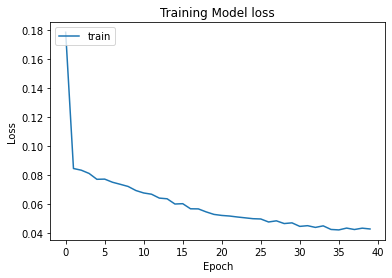

           date     Actual  Predicted
0    2018-07-27  47.023903  47.127650
1    2018-07-30  46.241833  47.052131
2    2018-07-31  45.982750  46.216658
3    2018-08-01  46.074760  46.301503
4    2018-08-02  48.789028  48.872222
..          ...        ...        ...
385  2020-02-07  80.486107  78.127160
386  2020-02-10  79.392090  78.304607
387  2020-02-11  79.769165  78.901505
388  2020-02-12  79.287888  78.910749
389  2020-02-13  81.170799  80.255852

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0463 - mean_squared_error: 0.0463
LSTM Model Loss =  [0.046345386654138565, 0.046345386654138565]
Model Accuracy =  99.15244088232868
Mean Absolute Error =  0.4394489842198696  degrees
Mean Squared Error =  0.390070235984507
Root Mean Squared Error =  0.624556031100899

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
y_test_original.shape (390, 1)
Epoch 1/

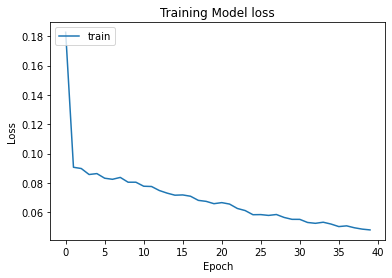

           date       Actual    Predicted
0    2018-07-27  1808.000000  1861.252950
1    2018-07-30  1817.270020  1852.823482
2    2018-07-31  1779.219971  1777.989440
3    2018-08-01  1777.439941  1806.047103
4    2018-08-02  1797.170044  1826.371128
..          ...          ...          ...
385  2020-02-07  2050.229980  2010.196522
386  2020-02-10  2079.280029  2046.345965
387  2020-02-11  2133.909912  2118.119369
388  2020-02-12  2150.800049  2131.383469
389  2020-02-13  2160.000000  2129.148065

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0465 - mean_squared_error: 0.0465
LSTM Model Loss =  [0.04647034406661987, 0.04647034406661987]
Model Accuracy =  99.07517127497037
Mean Absolute Error =  16.264886170639063  degrees
Mean Squared Error =  544.5300190351953
Root Mean Squared Error =  23.335167002513508

--------------------------------------------------------------------------

Evaluating Model for Company

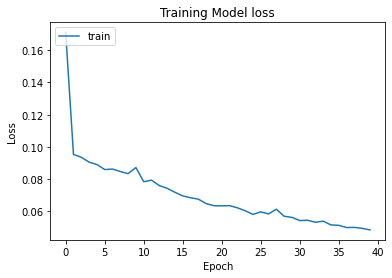

           date     Actual  Predicted
0    2018-07-27  43.653885  43.389857
1    2018-07-30  43.562386  43.397804
2    2018-07-31  43.324490  43.402274
3    2018-08-01  44.157127  44.222896
4    2018-08-02  44.019875  44.129891
..          ...        ...        ...
385  2020-02-07  44.165833  43.563150
386  2020-02-10  43.906483  43.614683
387  2020-02-11  43.877670  43.565538
388  2020-02-12  44.300312  43.617825
389  2020-02-13  44.155090  43.836817

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0427 - mean_squared_error: 0.0427
LSTM Model Loss =  [0.042744461447000504, 0.042744461447000504]
Model Accuracy =  99.43953632407914
Mean Absolute Error =  0.22997661041941286  degrees
Mean Squared Error =  0.11613639950981904
Root Mean Squared Error =  0.3407879098645065

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
y_test_original.shape (390, 1)
Epoc

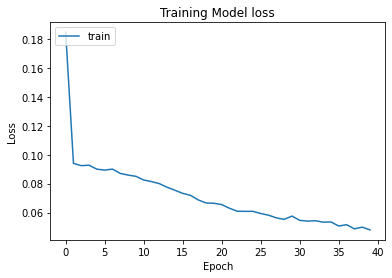

           date       Actual    Predicted
0    2018-07-27  1268.329956  1258.955874
1    2018-07-30  1238.500000  1252.209742
2    2018-07-31  1219.739990  1245.733955
3    2018-08-01  1217.260010  1238.312128
4    2018-08-02  1220.010010  1235.215209
..          ...          ...          ...
385  2020-02-07  1476.229980  1472.755947
386  2020-02-10  1479.229980  1470.682690
387  2020-02-11  1508.680054  1502.757757
388  2020-02-12  1508.790039  1500.545395
389  2020-02-13  1518.270020  1506.535883

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0580 - mean_squared_error: 0.0580
LSTM Model Loss =  [0.05796709284186363, 0.05796709284186363]
Model Accuracy =  99.16883351761632
Mean Absolute Error =  9.715731654956377  degrees
Mean Squared Error =  175.4140975085672
Root Mean Squared Error =  13.244398722047265

--------------------------------------------------------------------------

Evaluating Model for Company:

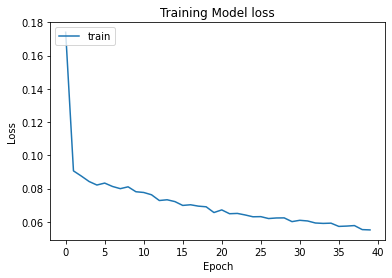

           date     Actual  Predicted
0    2018-07-27  33.331360  33.462567
1    2018-07-30  32.731140  33.773853
2    2018-07-31  32.595608  34.026841
3    2018-08-01  32.382629  34.324578
4    2018-08-02  32.034122  32.065175
..          ...        ...        ...
385  2020-02-07  37.343075  36.825483
386  2020-02-10  35.574196  36.641320
387  2020-02-11  35.397308  36.289260
388  2020-02-12  35.810051  36.020230
389  2020-02-13  36.507778  35.639238

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0482 - mean_squared_error: 0.0482
LSTM Model Loss =  [0.04816950857639313, 0.04816950857639313]
Model Accuracy =  99.11406124714775
Mean Absolute Error =  0.2997151947359708  degrees
Mean Squared Error =  0.18377508628071976
Root Mean Squared Error =  0.42868996522046066

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
y_test_original.shape (390, 1)
Epoch 1

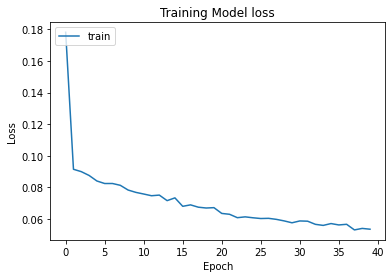

           date     Actual  Predicted
0    2018-07-27  71.726852  71.490915
1    2018-07-30  69.751480  71.466743
2    2018-07-31  69.598213  71.366239
3    2018-08-01  69.402374  71.266597
4    2018-08-02  68.448746  68.499810
..          ...        ...        ...
385  2020-02-07  56.346684  56.746676
386  2020-02-10  55.973351  56.205290
387  2020-02-11  55.382210  56.574750
388  2020-02-12  55.908691  56.676745
389  2020-02-13  56.592194  56.865120

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0480 - mean_squared_error: 0.0480
LSTM Model Loss =  [0.04798165708780289, 0.04798165708780289]
Model Accuracy =  99.35014747559948
Mean Absolute Error =  0.4291397617229655  degrees
Mean Squared Error =  0.3571241957586162
Root Mean Squared Error =  0.5975986912290021

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
y_test_original.shape (390, 1)
Epoch 1/4

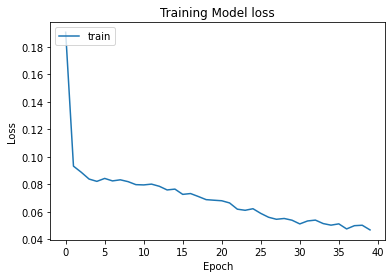

           date     Actual  Predicted
0    2018-07-27  63.071827  62.530661
1    2018-07-30  62.687599  62.423004
2    2018-07-31  62.601139  62.335799
3    2018-08-01  62.956558  62.431693
4    2018-08-02  62.226517  62.501050
..          ...        ...        ...
385  2020-02-07  88.100525  87.675487
386  2020-02-10  86.525017  87.428424
387  2020-02-11  86.948433  86.851678
388  2020-02-12  87.805115  86.663795
389  2020-02-13  87.430931  87.050704

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0582 - mean_squared_error: 0.0582
LSTM Model Loss =  [0.05822090804576874, 0.05822090804576874]
Model Accuracy =  99.2391817829131
Mean Absolute Error =  0.5683024886475218  degrees
Mean Squared Error =  0.5521021808332116
Root Mean Squared Error =  0.743035787047442

--------------------------------------------------------------------------



In [18]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = with_news_LSTM(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)


In [24]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.439449,0.390070,99.152441,0.624556
1,AMZN,16.264886,544.530019,99.075171,23.335167
2,ADM,0.229977,0.116136,99.439536,0.340788
3,GOOG,9.715732,175.414098,99.168834,13.244399
4,EBAY,0.299715,0.183775,99.114061,0.428690
5,XOM,0.429140,0.357124,99.350147,0.597599
6,ABT,0.568302,0.552102,99.239182,0.743036


In [26]:
# Mean Accuracy for With news
mean_results = company_results.mean(axis = 0)
mean_results

MAE           3.992457
MSE         103.077618
Accuracy     99.219910
RMSE          5.616319
dtype: float64

In [28]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P2_LSTM_All_Companies_with_news"+current_time+".csv"
company_results.to_csv(name)